## Main analysis for Capstone

Importing all libraries first

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE

First load the source csv file into `pandas`:

In [3]:
df_grand = pd.read_csv('~/Desktop/NSCLC-Radiomics-agg-padded.csv')

Define some boolean variables based on whether the patient has died (`deadstatus.event`==1) and the registered survival time of the patient. For this study, we look at the patients at 1-year, 3-year, and 5-year marks.

In [4]:
dead = df_grand['deadstatus.event'].astype(bool)

mask_1yr = (df_grand['Survival.time'] >= 365)
mask_3yr = (df_grand['Survival.time'] >= 3*365)
mask_5yr = (df_grand['Survival.time'] >= 5*365)

In [5]:
df_tf = df_grand.copy()

Transforming data based on EDA:

In [6]:
# Define an epsilon s.t. the argument to the log will be positive
eps = 0

for i in range(1):
    str_i = str(i)
    
    # Shape
    df_tf.drop(columns=['shape_VoxelVolume_'+str_i, 
                        'shape_Maximum2DDiameterColumn_'+str_i, 
                        'shape_Maximum2DDiameterRow_'+str_i], inplace=True)
    
    df_tf['log_shape_MeshVolume_'+str_i] = np.log( df_tf['shape_MeshVolume_'+str_i] + eps )
    df_tf.drop(columns=['shape_MeshVolume_' + str_i])
    
    # GLDM
    df_tf.drop(columns=['gldm_LargeDependenceEmphasis_'+str_i], 
               inplace = True)
    
    df_tf['log_gldm_GrayLevelVariance_' + str_i] = np.log(df_tf['gldm_GrayLevelVariance_' + str_i] + eps)
    df_tf['log_gldm_DependenceNonUniformity_' + str_i] = np.log(df_tf['gldm_DependenceNonUniformity_' + str_i] + eps)
    df_tf['log_gldm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['gldm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['bc_gldm_LargeDependenceLowGrayLevelEmphasis_' 
          + str_i] = boxcox(df_tf['gldm_LargeDependenceLowGrayLevelEmphasis_' + str_i] + eps)[0]
    df_tf['bc_gldm_SmallDependenceLowGrayLevelEmphasis_' 
          + str_i] = boxcox(df_tf['gldm_SmallDependenceLowGrayLevelEmphasis_' + str_i] + eps)[0]
    df_tf['bc_gldm_LowGrayLevelEmphasis_' + str_i] = boxcox(df_tf['gldm_LowGrayLevelEmphasis_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['gldm_GrayLevelVariance_' + str_i,
                        'gldm_DependenceNonUniformity_' + str_i,
                        'gldm_GrayLevelNonUniformity_' + str_i,
                        'gldm_LargeDependenceLowGrayLevelEmphasis_' + str_i,
                        'gldm_SmallDependenceLowGrayLevelEmphasis_' + str_i,
                        'gldm_LowGrayLevelEmphasis_' + str_i], inplace=True)
    
    # GLCM
    df_tf.drop(columns=['glcm_SumAverage_' + str_i, 
                        'glcm_JointAverage_' + str_i,
                        'glcm_SumEntropy_' + str_i,
                        'glcm_DifferenceEntropy_' + str_i,
                        'glcm_Id_' + str_i,
                        'glcm_Idn_' + str_i,
                        'glcm_ClusterTendency_' + str_i,
                        'glcm_Contrast_' + str_i], inplace=True)
    df_tf['bc_glcm_JointEnergy_' + str_i] = boxcox(df_tf['glcm_JointEnergy_' + str_i] + eps)[0]
    df_tf['log_glcm_DifferenceVariance_' + str_i] = np.log(df_tf['glcm_DifferenceVariance_' + str_i] + eps)
    df_tf['log_glcm_SumSquares_' + str_i] = np.log(df_tf['glcm_SumSquares_' + str_i] + eps)
    df_tf['bc_glcm_ClusterProminence_' + str_i] = boxcox(df_tf['glcm_ClusterProminence_' + str_i] + eps)[0]
    df_tf['bc_glcm_DifferenceAverage_' + str_i] = boxcox(df_tf['glcm_DifferenceAverage_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['glcm_JointEnergy_' + str_i,
                        'glcm_DifferenceVariance_' + str_i,
                        'glcm_SumSquares_' + str_i,
                        'glcm_ClusterProminence_' + str_i,
                        'glcm_DifferenceAverage_' + str_i], inplace=True)
    
    # First order
    df_tf.drop(columns=['firstorder_RobustMeanAbsoluteDeviation_' + str_i, 
                        'firstorder_MeanAbsoluteDeviation_' + str_i,
                        'firstorder_TotalEnergy_' + str_i], inplace=True)
    df_tf['bc_firstorder_InterquartileRange_' + str_i] = boxcox(df_tf['firstorder_InterquartileRange_' + str_i] + eps)[0]
    df_tf['log_firstorder_Energy_' + str_i] = np.log(df_tf['firstorder_Energy_' + str_i] + eps)
    df_tf['log_firstorder_Kurtosis_' + str_i] = np.log(df_tf['firstorder_Kurtosis_' + str_i] + eps)
    df_tf['log_firstorder_RootMeanSquared_' + str_i] = np.log(df_tf['firstorder_RootMeanSquared_' + str_i] + eps)
    
    # GLRLM
    df_tf.drop(columns=['glrlm_ShortRunLowGrayLevelEmphasis_' + str_i,
                        'glrlm_LowGrayLevelRunEmphasis_' + str_i,
                        'glrlm_LongRunEmphasis_' + str_i,
                        'glrlm_RunLengthNonUniformityNormalized_' + str_i,
                        'glrlm_ShortRunEmphasis_' + str_i], inplace=True)
    df_tf['log_glrlm_GrayLevelVariance_' + str_i] = np.log(df_tf['glrlm_GrayLevelVariance_' + str_i] + eps)
    df_tf['log_glrlm_RunVariance_' + str_i] = np.log(df_tf['glrlm_RunVariance_' + str_i] + eps)
    df_tf['log_glrlm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['glrlm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['log_glrlm_RunLengthNonUniformity_' + str_i] = np.log(df_tf['glrlm_RunLengthNonUniformity_' + str_i] + eps)
    df_tf['bc_glrlm_LongRunLowGrayLevelEmphasis_' + str_i] = boxcox(df_tf['glrlm_LongRunLowGrayLevelEmphasis_' 
                                                                          + str_i] + eps)[0]
    
    df_tf.drop(columns=['glrlm_GrayLevelVariance_' + str_i,
                        'glrlm_RunVariance_' + str_i,
                        'glrlm_GrayLevelNonUniformity_' + str_i,
                        'glrlm_RunLengthNonUniformity_' + str_i,
                        'glrlm_LongRunLowGrayLevelEmphasis_' + str_i], inplace = True)
    
    # GLSZM
    df_tf.drop(columns=['glszm_LargeAreaEmphasis_' + str_i,
                        'glszm_LargeAreaHighGrayLevelEmphasis_' + str_i,
                        'glszm_SmallAreaEmphasis_' + str_i,
                        'glszm_SmallAreaHighGrayLevelEmphasis_' + str_i,
                        'glszm_SmallAreaLowGrayLevelEmphasis_' + str_i], inplace=True)
    df_tf['log_glszm_GrayLevelVariance_' + str_i] = boxcox(df_tf['glszm_GrayLevelVariance_' + str_i] + eps)[0]
    df_tf['bc_glszm_ZoneVariance_' + str_i] = boxcox(df_tf['glszm_ZoneVariance_' + str_i] + eps)[0]
    df_tf['log_glszm_GrayLevelNonUniformityNormalized_' + str_i] = np.log(df_tf['glszm_GrayLevelNonUniformityNormalized_' 
                                                                                + str_i] + eps)
    df_tf['log_glszm_SizeZoneNonUniformity_' + str_i] = np.log(df_tf['glszm_SizeZoneNonUniformity_' + str_i] + eps)
    df_tf['log_glszm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['glszm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['log_glszm_ZonePercentage_' + str_i] = np.log(df_tf['glszm_ZonePercentage_' + str_i] + eps)
    df_tf['log_glszm_LargeAreaLowGrayLevelEmphasis_' + str_i] = np.log(df_tf['glszm_LargeAreaLowGrayLevelEmphasis_' 
                                                                             + str_i] + eps)
    df_tf['bc_glszm_LowGrayLevelZoneEmphasis_' + str_i] = boxcox(df_grand['glszm_LowGrayLevelZoneEmphasis_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['glszm_GrayLevelVariance_' + str_i,
                        'glszm_ZoneVariance_' + str_i,
                        'glszm_GrayLevelNonUniformityNormalized_' + str_i,
                        'glszm_SizeZoneNonUniformity_' + str_i,
                        'glszm_GrayLevelNonUniformity_' + str_i,
                        'glszm_ZonePercentage_' + str_i,
                        'glszm_LargeAreaLowGrayLevelEmphasis_' + str_i,
                        'glszm_LowGrayLevelZoneEmphasis_' + str_i], inplace=True)

In [16]:
# Number of features at the end
num_feat = len(df_tf.columns[df_tf.columns.str.contains('_0')])

---
### 1-year analysis:

We look at patients satisfying one of the two following criteria:
- The patient has passed away, and his/ her survival time is definite; OR
- The patient has survived past the 1-year mark regardless whether the patient has passed away

In [17]:
feat_mask = df_tf.columns.str.contains('_')
X1 = df_tf[mask_1yr | dead][df_tf.columns[feat_mask]]
y1 = (df_tf[mask_1yr | dead]['Survival.time']> 365).astype(int)

In [18]:
X1 = X1.astype(float)

Looking at the total number of patients being studied here:

In [19]:
y1.shape

(418,)

Split the data into training set and test set:

In [20]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=1)

Look at the class imbalance:

In [21]:
y1_train.value_counts()

1    190
0    102
Name: Survival.time, dtype: int64

Hence there are 190 patients in the training set who have survived for more than 1 year, and 102 who have not.

We scale all features in the training set such that all features centred at zero and have variances of 1. The test set is also scaled, BUT with the scaling factors determined from the training set:

In [22]:
my_scaler = StandardScaler()
X1_train = my_scaler.fit_transform(X1_train)
X1_test = my_scaler.transform(X1_test)

Then run through various models:

#### Logistic Regression

In [46]:
my_logit = LogisticRegression()
my_logit.fit(X1_train, y1_train)
my_logit.score(X1_train, y1_train)

0.7705479452054794

The test accuracy for the logistic regression model is:

In [47]:
my_logit.score(X1_test, y1_test)

0.6111111111111112

To further optimize the results, run a grid search:
- Try LASSO (i.e. `penalty='l1'`) and Ridge regression (i.e. `penalty='l2'`)
- Try different normalization strengths (for C, the inverse of the normalization strengths, ranging from $10^{-6}$ to $10^6$)

In [48]:
estimators = [('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'model': [LogisticRegression()], 
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

The optimized hyperparameters are:

In [49]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

The score on the training set is:

In [50]:
fittedgrid.score(X1_train, y1_train)

0.7671232876712328

While the score on the test set is:

In [51]:
fittedgrid.score(X1_test, y1_test)

0.6031746031746031

Plot some graphs! Define some lists first, then write into a dataframe:

In [52]:
logit_grid_C = fittedgrid.cv_results_['param_model__C'].data

logit_grid_penalty =fittedgrid.cv_results_['param_model__penalty'].data

logit_grid_score = fittedgrid.cv_results_['mean_test_score']

In [53]:
df_logit = pd.DataFrame({'C': logit_grid_C,
                         'penalty': logit_grid_penalty,
                         'score': logit_grid_score})
df_logit.head()

,C,penalty,score
0,1e-06,l1,0.349315
1,1e-06,l2,0.578767
2,1e-05,l1,0.349315
3,1e-05,l2,0.578767
4,0.0001,l1,0.349315


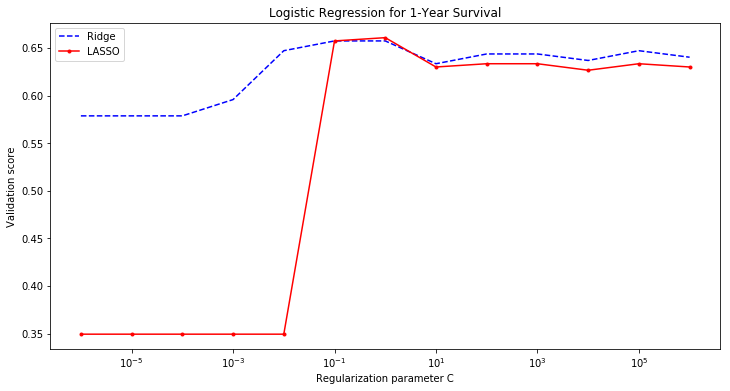

In [57]:
plt.figure(figsize=(12,6))
plt.plot(df_logit[df_logit['penalty']=='l2']['C'], df_logit[df_logit['penalty']=='l2']['score'], 'b--', label='Ridge')
plt.plot(df_logit[df_logit['penalty']=='l1']['C'], df_logit[df_logit['penalty']=='l1']['score'], 'r.-', label='LASSO')
plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

Since the accuracy score is so low, and there is a slight imbalance in the classes, let us print out the f1-score and the confusion matrix also for the test set:

In [30]:
y_pred_logit = fittedgrid.predict(X1_test)
print(classification_report(y1_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.45      0.33      0.38        46
           1       0.67      0.78      0.72        80

    accuracy                           0.61       126
   macro avg       0.56      0.55      0.55       126
weighted avg       0.59      0.61      0.59       126



Repeat the logistic regression with principal component analysis:

In [70]:
estimators = [('pca', PCA()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'model': [LogisticRegression()], 
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid_pca = grid.fit(X1_train, y1_train)

In [71]:
fittedgrid_pca.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [72]:
fittedgrid_pca.score(X1_train, y1_train)

0.6917808219178082

In [73]:
fittedgrid_pca.score(X1_test, y1_test)

0.6190476190476191

In [74]:
y_pred_logit_pca = fittedgrid_pca.predict(X1_test)
print(classification_report(y1_test, y_pred_logit_pca))

              precision    recall  f1-score   support

           0       0.45      0.20      0.27        46
           1       0.65      0.86      0.74        80

    accuracy                           0.62       126
   macro avg       0.55      0.53      0.51       126
weighted avg       0.58      0.62      0.57       126



In [75]:
logit_pca_grid_C = fittedgrid_pca.cv_results_['param_model__C'].data

logit_pca_grid_penalty =fittedgrid_pca.cv_results_['param_model__penalty'].data

logit_pca_grid_score = fittedgrid_pca.cv_results_['mean_test_score']

logit_pca_grid_n_components = fittedgrid_pca.cv_results_['param_pca__n_components'].data

In [76]:
df_logit_pca = pd.DataFrame({'C': logit_pca_grid_C,
                             'penalty': logit_pca_grid_penalty,
                             'n_components': logit_pca_grid_n_components,
                             'score': logit_pca_grid_score})
df_logit_pca.head()

,C,penalty,n_components,score
0,1e-06,l1,5,0.349315
1,1e-06,l1,10,0.349315
2,1e-06,l1,15,0.349315
3,1e-06,l1,20,0.349315
4,1e-06,l1,25,0.349315


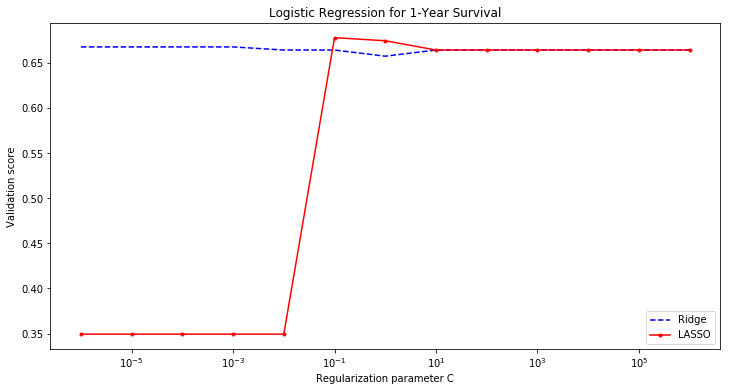

In [77]:
plt.figure(figsize=(12,6))
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['n_components']==15)]['C'], 
         df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['n_components']==15)]['score'], 'b--', label='Ridge')
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['n_components']==15)]['C'], 
         df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['n_components']==15)]['score'], 'r.-', label='LASSO')
plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

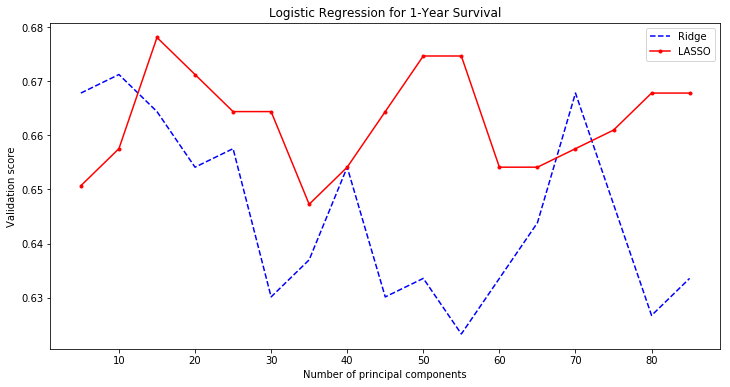

In [78]:
plt.figure(figsize=(12,6))
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['C']==0.1)]['n_components'], 
         df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['C']==0.1)]['score'], 'b--', label='Ridge')
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['C']==0.1)]['n_components'], 
         df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['C']==0.1)]['score'], 'r.-', label='LASSO')
plt.xlabel('Number of principal components')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

In [79]:
fittedgrid_pca.score(X1_train, y1_train)

0.6917808219178082

In [80]:
fittedgrid_pca.score(X1_test, y1_test)

0.6190476190476191

In [81]:
y1_pred_pca = fittedgrid_pca.predict(X1_test)
print(classification_report(y1_test, y1_pred_pca))

              precision    recall  f1-score   support

           0       0.45      0.20      0.27        46
           1       0.65      0.86      0.74        80

    accuracy                           0.62       126
   macro avg       0.55      0.53      0.51       126
weighted avg       0.58      0.62      0.57       126



#### Decision Tree

In [82]:
estimators = [('pca', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'model': [DecisionTreeClassifier()],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,6)],
               'pca__n_components': [x for x in range(5,num_feat,5)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

In [83]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=6, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)

In [84]:
fittedgrid.best_score_

0.6541095890410958

In [86]:
fittedgrid.score(X1_train, y1_train)

0.8287671232876712

In [87]:
fittedgrid.score(X1_test, y1_test)

0.6507936507936508

#### Random Forest

In [45]:
my_rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=32)
my_rf.fit(X1_reshape_train, y1_train)
my_rf.score(X1_reshape_train, y1_train)

0.8664383561643836

In [46]:
my_rf.score(X1_reshape_test, y1_test)

0.6349206349206349

In [47]:
y_pred_rf = my_rf.predict(X1_reshape_test)
print(classification_report(y1_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.50      0.17      0.26        46
           1       0.65      0.90      0.76        80

    accuracy                           0.63       126
   macro avg       0.58      0.54      0.51       126
weighted avg       0.60      0.63      0.58       126



#### XGBoost decision tree

In [48]:
estimators = [('model', XGBClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'model': [XGBClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__n_estimators': [i for i in range(10,160,10)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_reshape_train, y1_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
fittedgrid.best_params_

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=1,
               min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1),
 'model__max_depth': 1,
 'model__n_estimators': 10,
 'normalise': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [50]:
fittedgrid.best_score_

0.6541095890410958

In [51]:
fittedgrid.score(X1_reshape_test, y1_test)

0.626984126984127

In [52]:
xgb_grid_maxdepth = fittedgrid.cv_results_['param_model__max_depth'].data
xgb_grid_n_estimators = fittedgrid.cv_results_['param_model__n_estimators'].data
xgb_grid_score = fittedgrid.cv_results_['mean_test_score']

In [53]:
df_xgb = pd.DataFrame({'max_depth': xgb_grid_maxdepth,
                       'n_estimators': xgb_grid_n_estimators,
                       'score': xgb_grid_score})

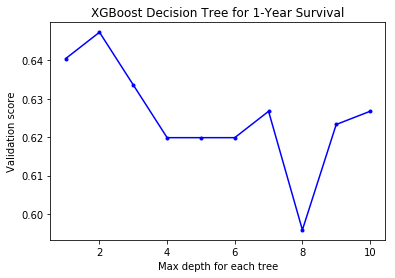

In [54]:
plt.figure()
plt.plot(df_xgb[df_xgb['n_estimators']==30]['max_depth'], df_xgb[df_xgb['n_estimators']==30]['score'], 'b.-')
plt.xlabel('Max depth for each tree')
plt.ylabel('Validation score')
plt.title('XGBoost Decision Tree for 1-Year Survival')
plt.show()

#### Support Vector Machine

In [55]:
estimators = [('normalise', StandardScaler()),
              ('model', SVC())]

pipe = Pipeline(estimators)

param_grid = [{'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'normalise': [StandardScaler()],
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_reshape_train, y1_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [56]:
fittedgrid.best_params_

{'model': SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
     kernel='poly', max_iter=999, probability=False, random_state=None,
     shrinking=True, tol=0.001, verbose=False),
 'model__C': 0.1,
 'model__kernel': 'poly',
 'normalise': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [57]:
fittedgrid.best_score_

0.6541095890410958

In [58]:
fittedgrid.score(X1_reshape_test, y1_test)

0.6428571428571429

---

### 3-year analysis
For the patients surviving for more than 3 years

In [13]:
X3 = df_tf[mask_3yr | dead][df_tf.columns[feat0]]
y3 = (df_tf[mask_3yr | dead]['Survival.time'] > 3*365).astype(int)

X3 = X3.astype(float)

In [14]:
y3.shape

(418,)

In [15]:
y3.value_counts()

0    288
1    130
Name: Survival.time, dtype: int64

In [22]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=1)

In [23]:
y3_train.value_counts()

0    203
1     89
Name: Survival.time, dtype: int64

In [92]:
my_scaler3 = StandardScaler()
X3_train = my_scaler3.fit_transform(X3_train)
X3_test = my_scaler3.transform(X3_test)

In [93]:
my_logit3 = LogisticRegression()
my_logit3.fit(X3_train, y3_train)
my_logit3.score(X3_train, y3_train)

0.7465753424657534

In [94]:
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'model': [LogisticRegression()], 
               'normalise': [StandardScaler()],
               'model__C': [10**i for i in range(-6,7)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [95]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [96]:
fittedgrid3.best_score_

0.6438356164383562

In [97]:
my_logit3.score(X3_test, y3_test)

0.6507936507936508

In [98]:
fittedgrid3.score(X3_test, y3_test)

0.6666666666666666

In [99]:
my_dt3 = DecisionTreeClassifier(max_depth=5)
my_dt3.fit(X3_train, y3_train)
my_dt3.score(X3_train, y3_train)

0.886986301369863

In [100]:
my_dt3.score(X3_test, y3_test)

0.6111111111111112

In [101]:
estimators = [('normalise', StandardScaler()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'model': [DecisionTreeClassifier()], 
               'normalise': [StandardScaler()],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [102]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=1, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)

In [103]:
fittedgrid3.best_score_

0.6952054794520548

In [104]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

In [105]:
my_rf3 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=32)
my_rf3.fit(X3_train, y3_train)
my_rf3.score(X3_train, y3_train)

0.9075342465753424

In [106]:
my_rf3.score(X3_test, y3_test)

0.6587301587301587

In [107]:
y3_pred_rf = my_rf3.predict(X3_test)
print(classification_report(y3_test, y3_pred_rf))

              precision    recall  f1-score   support

           0       0.68      0.92      0.78        85
           1       0.42      0.12      0.19        41

    accuracy                           0.66       126
   macro avg       0.55      0.52      0.49       126
weighted avg       0.60      0.66      0.59       126



In [108]:
estimators = [('normalise', StandardScaler()),
              ('model', RandomForestClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'model': [RandomForestClassifier()], 
               'normalise': [StandardScaler()],
               'model__n_estimators': [i for i in range(10,110,10)],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [109]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=1,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=7, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [110]:
fittedgrid3.best_score_

0.6986301369863014

In [111]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

In [112]:
estimators = [('normalise', StandardScaler()),
              ('model', XGBClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'model': [XGBClassifier()], 
               'normalise': [StandardScaler()],
               'model__max_depth': [i for i in range(1,11)],
               'model__n_estimators': [i for i in range(10,160,10)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [113]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=1,
                               min_child_weight=1, missing=None,
                               n_estimators=10, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [114]:
fittedgrid3.best_score_

0.6883561643835616

In [115]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

In [116]:
estimators = [('normalise', StandardScaler()),
              ('model', SVC())]

pipe = Pipeline(estimators)

param_grid = [{'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'normalise': [StandardScaler()],
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [117]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 SVC(C=1e-06, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovo', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=999,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [118]:
fittedgrid3.best_score_

0.6952054794520548

In [119]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

---

### 5-year analysis
For the patients surviving for 5 years:

In [16]:
X5 = df_tf[mask_5yr | dead][df_tf.columns[feat0]]
y5 = (df_tf[mask_5yr | dead]['Survival.time'] > 5*365).astype(int)

X5 = X5.astype(float)

In [17]:
y5.shape

(406,)

In [19]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=1)

In [20]:
y5_train.value_counts()

0    233
1     51
Name: Survival.time, dtype: int64

In [ ]:
my_scaler5 = StandardScaler()
X5_train = my_scaler5.fit_transform(X5_train)
X5_test = my_scaler5.transform(X5_test)

In [ ]:
my_logit5 = LogisticRegression()
my_logit5.fit(X5_train, y5_train)
my_logit5.score(X5_train, y5_train)

In [ ]:
my_logit5.score(X5_test, y5_test)

In [ ]:
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'model': [LogisticRegression()], 
               'normalise': [StandardScaler()],
               'model__C': [10**i for i in range(-6,7)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

In [ ]:
fittedgrid5.best_estimator_

In [ ]:
fittedgrid5.best_score_

In [ ]:
fittedgrid5.score(X5_test, y5_test)

In [ ]:
y5_train.value_counts()

High accuracy score due to imbalanced dataset. Conventional SMOTE, ADASYN and SVMSMOTE yielded WORSE results.

In [ ]:
X5_train_resampled, y5_train_resampled = SVMSMOTE().fit_resample(X5_train, y5_train)

In [ ]:
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'model': [LogisticRegression()], 
               'normalise': [StandardScaler()],
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid5 = grid.fit(X5_train_resampled, y5_train_resampled)

In [ ]:
fittedgrid5.best_score_

In [ ]:
fittedgrid5.best_estimator_

In [ ]:
fittedgrid5.score(X5_test, y5_test)

In [ ]:
y5_pred = fittedgrid5.predict(X5_test)
print(classification_report(y5_test, y5_pred))

In [ ]:
print('Kappa score: %.5f' % cohen_kappa_score(y5_test, y5_pred))

In [ ]:
my_dt5 = DecisionTreeClassifier(max_depth=5)
my_dt5.fit(X5_train, y5_train)
my_dt5.score(X5_train, y5_train)

In [ ]:
my_dt5.score(X5_test, y5_test)

---

## Miscellaneous and superceded codes:

In [17]:
my_pca = PCA(n_components=40)
my_pca.fit(X1_train)
X1_pca_train = my_pca.transform(X1_train)
X1_pca_test = my_pca.transform(X1_test)

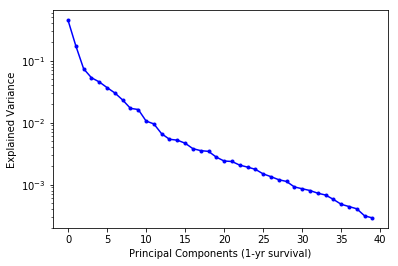

In [18]:
plt.figure()
plt.plot(range(len(my_pca.explained_variance_ratio_)), my_pca.explained_variance_ratio_, 'b.-')
plt.xlabel('Principal Components (1-yr survival)')
plt.ylabel('Explained Variance')
plt.yscale('log')
plt.show()

Just keep the first 30:

In [19]:
X1_reshape_train = X1_pca_train[:,:30]
X1_reshape_test = X1_pca_test[:,:30]

In [30]:
# Try to do it without PCA
X1_reshape_train = X1_train
X1_reshape_test = X1_test

In [20]:
my_logit = LogisticRegression()
my_logit.fit(X1_reshape_train, y1_train)
my_logit.score(X1_reshape_train, y1_train)

0.7226027397260274

In [21]:
my_logit.score(X1_reshape_test, y1_test)

0.6349206349206349

In [22]:
logit1_ind = []
logit1_mean_score = []

for i in range(-6,7):
    pow_10 = 10**i
    my_logit_cv = LogisticRegression(C=pow_10)
    
    logit1_ind.append(pow_10)
    logit1_mean_score.append(np.mean(cross_val_score(my_logit_cv, X1_reshape_train, y1_train, cv=5)))

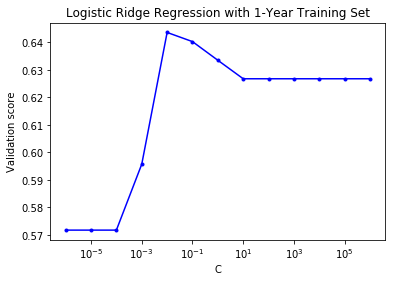

In [23]:
plt.figure()
plt.plot(logit1_ind, logit1_mean_score, 'b.-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Validation score')
plt.title('Logistic Ridge Regression with 1-Year Training Set')
plt.show()

In [24]:
my_logit_C = LogisticRegression(C=0.01)
my_logit_C.fit(X1_reshape_train, y1_train)
my_logit_C.score(X1_reshape_train, y1_train)

0.6952054794520548

In [25]:
my_logit_C.score(X1_reshape_test, y1_test)

0.626984126984127

In [27]:
y_pred_logitC = my_logit_C.predict(X1_reshape_test)
print(classification_report(y1_test, y_pred_logitC))

              precision    recall  f1-score   support

           0       0.49      0.43      0.46        46
           1       0.69      0.74      0.72        80

    accuracy                           0.63       126
   macro avg       0.59      0.59      0.59       126
weighted avg       0.62      0.63      0.62       126



In [28]:
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'model': [LogisticRegression()], 
               'normalise': [StandardScaler()],
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_reshape_train, y1_train)

In [29]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('normalise',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [30]:
fittedgrid.best_score_

0.660958904109589

In [31]:
fittedgrid.score(X1_reshape_test, y1_test)

0.6349206349206349

In [37]:
my_dt = DecisionTreeClassifier(max_depth=5)
my_dt.fit(X1_reshape_train, y1_train)
my_dt.score(X1_reshape_train, y1_train)

0.8424657534246576

In [38]:
my_dt.score(X1_reshape_test, y1_test)

0.6111111111111112

In [39]:
y_pred_dt = my_dt.predict(X1_reshape_test)
print(classification_report(y1_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.46      0.35      0.40        46
           1       0.67      0.76      0.71        80

    accuracy                           0.61       126
   macro avg       0.56      0.56      0.55       126
weighted avg       0.59      0.61      0.60       126

